In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
output_path = '/home/bruce1996/data/pr/0627/'

In [9]:
metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
selected_df = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt',sep = '\t',header=None)
selected_s = selected_df.iloc[:,0].values
candidate_df = meta_df.loc[selected_s,:]

In [65]:
import matplotlib
import markov_clustering as mc

def create_corr_network(df,method = 'spearman') :
    corr_m = df.T.corr(method)
    np.fill_diagonal(corr_m.values, 0)
    ut = np.triu(corr_m,k=1)
    ut = np.where(ut==0, np.nan, ut)
    ut_df = pd.DataFrame(ut,index = corr_m.index,columns = corr_m.columns)
    tmp = ut_df
    tmp['taxa'] = ut_df.index
    tmp = tmp.melt(id_vars='taxa')
    tmp.columns = ['t1','t2','weight']

    idx = tmp['weight'].isnull() == False
    tmp = tmp.loc[idx,:]
    G = nx.from_pandas_edgelist(tmp,'t1','t2',['weight'])
    #add node attribute
    pv_lambda = lambda x : 100 * (sum(x > 0) / len(x))
    pv = list(map(pv_lambda,meta_df.to_numpy()))
    pv_dict = dict(zip(meta_df.index,pv))

    m_ab = meta_df.mean(axis=1)
    mab_dict = dict(zip(meta_df.index,m_ab))
    nx.set_node_attributes(G,pv_dict,name='Prevalence')
    nx.set_node_attributes(G,mab_dict,name='Mean abundance')

    return G

def filter_corr_network(g,threshold,pos_only=False,p_color = '#66c2a5',n_color='#fc8d62'):
    g_c = g.copy()
    color_dict = dict()
    #p_color = ImageColor.getcolor(p_color, "RGB")
    #n_color = ImageColor.getcolor(n_color, "RGB")
    for n1,n2,w in g_c.edges(data=True) :
        if pos_only :
            if w['weight'] < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
        else :
            if abs(w['weight']) < threshold :
                g.remove_edge(n1,n2)
            else :
                #add color attribute
                if w['weight'] > 0 :
                    color_dict[(n1,n2)] = p_color
                else :
                    color_dict[(n1,n2)] = n_color
    nx.set_edge_attributes(g,color_dict,name='Color')
    #remove node degree = 1
    g_c = g.copy()
    for n,d in g_c.degree :
        if d < 2 :
            g.remove_node(n)

def subgraph(g,candidate,attr) :
    g_c = g.copy()
    cl = list(nx.get_node_attributes(g,attr).values())
    nl = list(g.nodes())
    for i in range(len(cl)) :
        if cl[i] != candidate :
            g_c.remove_node(nl[i])
    return g_c


def mcl_clustering(G) :

    matrix = nx.to_scipy_sparse_matrix(G,dtype=np.float32)
    result = mc.run_mcl(matrix)           
    clusters = mc.get_clusters(result)

    cluster_dict = dict()
    color_dict = dict()
    #set color for mcl clusters
    cmap = plt.cm.gist_rainbow
    n_cluster = len(clusters)
    colors = cmap(np.linspace(0., 1., n_cluster))

    node_list = list(G.nodes().keys())
    n_c = 0
    for i in range(len(clusters)) :
        if len(clusters[i]) < 2 :
            n = node_list[clusters[i][0]]
            cluster_dict[n] = 'No cluster'
            color_dict[n] = matplotlib.colors.rgb2hex(np.array([192/255,192/255,192/255,1]))
        else :
            for j in range(len(clusters[i])) :
                n = node_list[clusters[i][j]]
                cluster_dict[n] = "Cluster " + str(n_c)
                color_dict[n] = matplotlib.colors.rgb2hex(colors[n_c])
            n_c += 1
    nx.set_node_attributes(G,cluster_dict,'Cluster')
    nx.set_node_attributes(G,color_dict,'Color')

def plot_corr_network(G,title,fig_output,fontsize=None,figsize = (20,12)) :

    plt.figure(figsize = figsize)
    #pos = nx.spring_layout(G,k = 4 / sqrt(G.order()))
    pos = nx.spring_layout(G)
    #pos = nx.multipartite_layout(G,subset_key='Cluster')
    #plot node
    node_color_list = nx.get_node_attributes(G,'Color').values()
    nx.draw_networkx_nodes(G,pos,node_color=node_color_list,alpha=0.8,node_size = [v[1] ** 3 for v in G.degree]) 
    species = list(pos.keys())
    for idx in range(len(pos)) :
        s = species[idx]
        x = pos[s][0]
        y = pos[s][1]
        if fontsize == None :
            plt.text(x,y,s,fontsize = G.degree[s],horizontalalignment='center',verticalalignment='center')  
        else :
            plt.text(x,y,s,fontsize = fontsize,horizontalalignment='center',verticalalignment='center')
    #plot edge
    edge_color = nx.get_edge_attributes(G,'Color').values()
    nx.draw_networkx_edges(G,pos,edge_color=edge_color)
    #plot legend
    node_cluser_list = nx.get_node_attributes(G,'Cluster').values()
    legend_dict = dict(zip(node_cluser_list,node_color_list))
    
    for cl,col in legend_dict.items() :
        plt.plot([],[],color = col,label = cl)
    
    plt.legend()
    plt.title(title,fontsize = 15)
    plt.savefig(fig_output)
    plt.show()

def number_of_mcl_cluster(g) :
    cl = list(nx.get_node_attributes(g,'Cluster').values())
    nl = list(g.nodes().keys())
    degree_list = [x[1] for x in g.degree]
    df = pd.DataFrame({'Species' : nl,'Cluster' : cl,'Degree' : degree_list})
    for i in list(set(df['Cluster'])) :
        num = sum(df['Cluster'] == i)
        print('Number of node in %s : %d' % (i,num))

def degree_barplot(G,title,fig_output) :
    
    n_node = len(G.nodes())
    d_array = np.empty(n_node,dtype=int)
    n_array = np.empty(n_node,dtype=object)
    idx = 0
    for n,d in G.degree() :
        n_array[idx] = n
        d_array[idx] = d
        idx += 1
    plot_df = pd.DataFrame({'Species' : n_array,'Degree' : d_array})
    plot_df = plot_df.sort_values(by='Degree',ascending=False)
    plt.figure(figsize=(15,6))
    sns.barplot(data=plot_df,x='Species',y='Degree')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(fig_output,dpi=300)

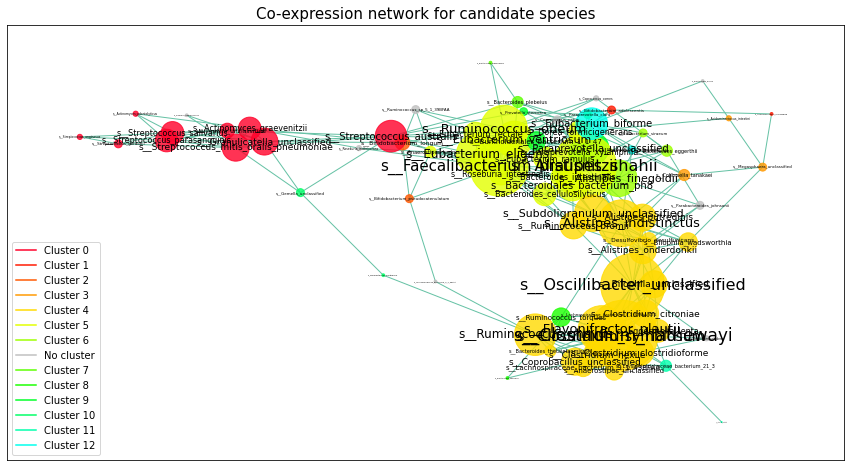

<Figure size 432x288 with 0 Axes>

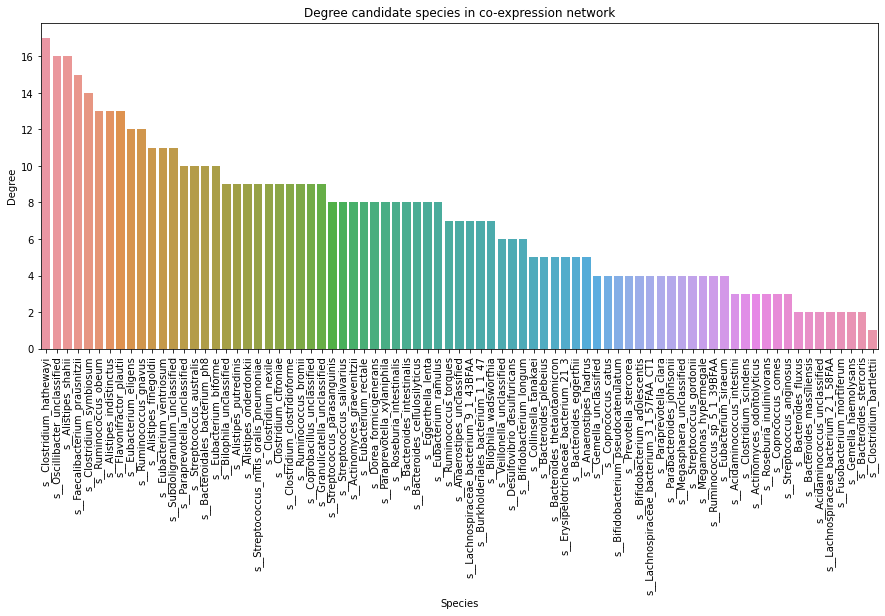

In [18]:
g = create_corr_network(candidate_df)
filter_corr_network(g,0.25,pos_only=True)
mcl_clustering(g)
plot_corr_network(g,'Co-expression network for candidate species',  'co-expression.png',figsize = (15,8))
degree_barplot(g,'Degree candidate species in co-expression network',  'degree_co_expression.png')

In [71]:
def node_prevalence(G,df,label,title,fig_output,xlabel,ylabel,measure='pv') :
    s = list(G.nodes)
    df = df.loc[s,:]
    if measure == 'pv' :
        pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
        x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
        y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    elif measure == 'mab' :
        x = df.loc[:,label].mean(axis=1)
        y = df.loc[:,label == False].mean(axis=1)
    plt.scatter(x = x,y=y,c=y,cmap='rainbow')
    mi= min(min(x),min(y))
    ma = max(max(x),max(y))
    plt.plot([0,ma],[0,ma], 'r-')

    if measure == 'pv' :
        plt.xlim([mi-5,ma+5])
        plt.ylim([mi-5,ma+5])
    elif measure == 'mab' :
        plt.xlim([mi-0.05,ma+0.05])
        plt.ylim([mi-0.05,ma+0.05])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(fig_output)
    plt.show()


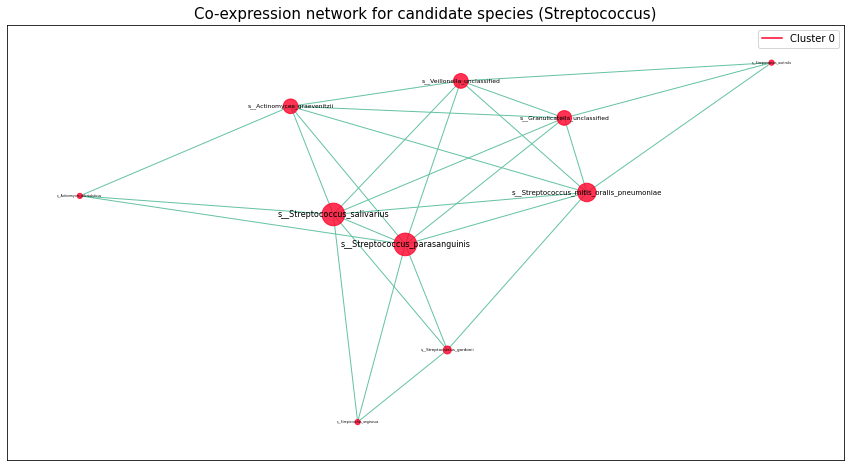

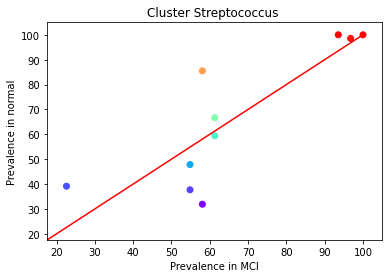

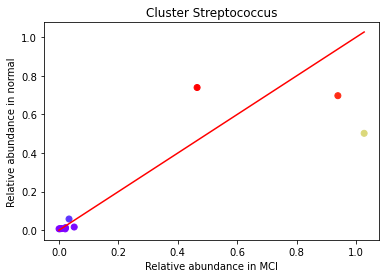

In [76]:
g_c = subgraph(g,attr='Cluster',candidate='Cluster 0')
plot_corr_network(g_c,'Co-expression network for candidate species (Streptococcus)', output_path + 'co-expression-cluster0.png',figsize = (15,8))
l  = np.where(metadata['Diagnosis'] == 'MCI',True,False)
node_prevalence(g_c,candidate_df,l,'Cluster Streptococcus ',output_path + 'cluster0-pv-scatterplpt.png','Prevalence in MCI','Prevalence in normal',measure='pv')
node_prevalence(g_c,candidate_df,l,'Cluster Streptococcus',output_path + 'cluster0-mab-scatterplpt.png','Relative abundance in MCI','Relative abundance in normal',measure='mab')